In [251]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
import statsmodels.formula.api as smf
from math import exp
from sklearn import linear_model, cross_validation
from scipy.optimize import lsq_linear
import scipy.stats as prr
import numpy as np
from IPython.display import display, HTML
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.formula.api as sm
import itertools

## Regression Class

In [252]:
class Regression:
    def __init__(self, pathToData):
        self.data = pd.read_csv(pathToData, index_col=0)

    def getDataFrame(self):
        return self.data

    
    
    # get collinearity (r^2 value) of a pair of columns
    def getCollinearityScore(self, dependentCol, independentCol):
        array = self.data.values
        X = array[:, independentCol]
        Y = array[:, dependentCol]

        return prr.pearsonr(X, Y)
        # GET SUBTABLE CONTAINING ONLY THE INDEPENDENT COLUMN AND DEPENDENT COLUMN
        # df2 = self.data.iloc[:, [independentCol, dependentCol]]
        # CREATE FITTED MODEL USING ORDINARY LEAST SQUARES REGRESSION
        # lm = smf.ols(formula='Sales ~ TV', data=df2).fit()
        # RETURN RSQUARED VALUE FOR THE MODEL
        # return lm.rsquared

    # print collinearities (r^2 value) of each pair of columns
    def printAllCollinearities(self):
        array = self.data.values
        length_col = self.data.shape[1]
        while(0 != length_col-1):
            for x in range(0, length_col-1):
                X = array[:, x]
                Y = array[:, length_col-1]

                print("Collinearity between "+self.data.columns.values[x]+" & "+self.data.columns.values[length_col-1]+" = "+str(prr.pearsonr(X, Y)))
            length_col -= 1

    def getSubTable(self, col_names):
        array = self.data
        return array.loc[:, col_names]
            
    def getFittedRegressionModel(self, col_names, dependent_col_name):
        array = self.data
        X = array.loc[:, col_names]
        Y = array.loc[:, dependent_col_name]
        model = linear_model.LinearRegression()
        model.fit(X, Y)
        print("R^2 score: "+str(model.score(X, Y)))
        m = model.coef_
        b = model.intercept_
        # print("Intercept=" + str(b) + " Coefficient=" + str(m))
        return model

    def getBestFeaturesRCEV(self, col_names, dependent_col_name):
        array = self.data
        X = array.loc[:, col_names]
        Y = array.loc[:, dependent_col_name]
        feature_names = self.data.columns.values
        model = linear_model.LinearRegression()
        selector = RFECV(estimator=model, cv=10)
        selector.fit(X, Y)
        print(selector.ranking_)
        print("Optimal number of features3: " + str(selector.n_features_))
        print(sorted(zip(map(lambda x: round(x, 4), selector.ranking_), col_names)))
        print(selector.support_)
        
    def getXVals(self, col_names):
        #array = self.data
        array = self.data.copy()
        X = array.loc[:, col_names]
        return X
    
    def getYVals(self, col_names):
        #array = self.data
        array = self.data.copy()
        X = array.loc[:, col_names]
        return X
        
    def kFoldTest(self, col_names, dependent_col_name, test_row_num):
        #array = self.data
        array = self.data.copy()
        array = array.drop(array.index[test_row_num])
        
        X = array.loc[:, col_names]
        Y = array.loc[:, dependent_col_name]
        model = linear_model.LinearRegression()
        model.fit(X, Y)
        m = model.coef_
        b = model.intercept_
        return model
    
    def kFoldTest2(self, col_names, dependent_col_name, slice_size):
        #array = self.data
        array = self.data.copy()
        original = self.data.copy()
        iterations = len(array.index)/slice_size
        #print("ITERATIONS: "+str(iterations))
        if(len(array.index)%slice_size>0):
            iterations = int(iterations)+1
        iterations = int(iterations)
        for j in range(0, iterations):
            for i in range(0,len(array.index)):
                if (i/slice_size==j):
                    array = array.drop(array.index[i])

            X = array.loc[:, col_names]
            Y = array.loc[:, dependent_col_name]
            
            A = np.array(X.values)
            b = np.array(Y.values)
            res = lsq_linear(A, b, bounds=(0, 600), lsmr_tol='auto', verbose=1);
            #print(res['x'])
            
            
            model = linear_model.LinearRegression()
            model.fit(X, Y)
            model.coef_ = res['x']
            model.intercept_ = 0
            m = model.coef_
            b = model.intercept_
            
            predicted_vals = []
            observed_vals = []
            array = self.data.copy()
            X = array.loc[:, col_names]
            Y = array.loc[:, dependent_col_name]
            size = 0
            for i in range(0,len(array.index)):
                #print(str(i)+" / "+str(slice_size)+" == "+str(j))
                if (int(i/slice_size)==j):
                    #print("WENT IN!")
                    size += 1
                    #print("length:"+str(len(X.index))+" index:"+str(i))
                    predicted_vals.append(model.predict(X.iloc[i , :].values.reshape(1,-1))[0])
                    #print("ans: "+str(Y.iloc[i]))
                    print("pred: "+str(model.predict(X.iloc[i , :].values.reshape(1,-1))[0]))
                    observed_vals.append(Y.iloc[i])
            rms1 = sqrt(mean_squared_error(observed_vals, predicted_vals))
            #print("rms1:"+str(rms1)+" * "+str((100*slice_size)/sum(observed_vals)))
            rms2 = rms1*((100*slice_size)/sum(observed_vals))
            print("Trained using slice "+str(j)+": RawRMSE="+str(rms1)+" %RMSE="+str(rms2))  
            #print("slice size: "+str(size))
            
    def statsmodelsRegressionSummary(self, col_names, dependent_col_name):
        array = self.data.copy()
        X = array.loc[:, col_names]
        Y = array.loc[:, dependent_col_name]
        result = sm.OLS( Y, X ).fit()
        return result

    def kFoldTest3(self, col_names, dependent_col_name, slice_size):
        total_rmse = 0
        #array = self.data
        array = self.data.copy()
        original = self.data.copy()
        iterations = len(array.index)/slice_size
        #print("ITERATIONS: "+str(iterations))
        if(len(array.index)%slice_size>0):
            iterations = int(iterations)+1
        iterations = int(iterations)
        for j in range(0, iterations):
            for i in range(0,len(array.index)):
                if (i/slice_size==j):
                    array = array.drop(array.index[i])

            X = array.loc[:, col_names]
            Y = array.loc[:, dependent_col_name]
            model = linear_model.LinearRegression()
            model.fit(X, Y)
            m = model.coef_
            b = model.intercept_
            
            predicted_vals = []
            observed_vals = []
            array = self.data.copy()
            X = array.loc[:, col_names]
            Y = array.loc[:, dependent_col_name]
            size = 0
            for i in range(0,len(array.index)):
                #print(str(i)+" / "+str(slice_size)+" == "+str(j))
                if (int(i/slice_size)==j):
                    #print("WENT IN!")
                    size += 1
                    #print("length:"+str(len(X.index))+" index:"+str(i))
                    predicted_vals.append(model.predict(X.iloc[i , :].values.reshape(1,-1))[0])
                    #print(Y.iloc[i])
                    observed_vals.append(Y.iloc[i])
            rms = sqrt(mean_squared_error(observed_vals, predicted_vals))
            rms = rms*((100*slice_size)/sum(observed_vals))
            total_rmse = total_rmse + rms
        return total_rmse


## Trip Generation Class

In [253]:
class TripGeneration:

    def __init__(self, pathToData, dependent_col_name):
        self.pathToData = pathToData
        self.dependent_col_name = dependent_col_name
        self.production_col_names = []
        self.production_constant = 0
        self.production_intercepts = []
        self.attraction_col_names = []
        self.attraction_constant = 0
        self.attraction_intercepts = []
        self.production_score = 0
        self.attraction_score = 0
        self.balancing_factor = 0
        
    def printAttributes(self):
        print("Attributes")
        print(self.production_col_names)
        print(self.production_constant)
        print(self.production_intercepts)
        print(self.attraction_col_names)
        print(self.attraction_constant)
        print(self.attraction_intercepts)

    def setProductionParameters(self, production_col_names, production_constant, production_intercepts):
        self.production_col_names = production_col_names
        self.production_constant = production_constant
        self.production_intercepts = production_intercepts
        
    def setAttractionParameters(self, attraction_col_names, attraction_constant, attraction_intercepts):
        self.attraction_col_names = attraction_col_names
        self.attraction_constant = attraction_constant
        self.attraction_intercepts = attraction_intercepts
        
    
    # get trip production score for 'zone'
    def getWholeTripProductionScore(self):
        data = pd.read_csv(self.pathToData, index_col=0)
        # implement specific way to get sub-table(data) just for specific 'zone' i.e: all rows related to zone1
        sub_table = data.loc[:, self.production_col_names]
        length_rows = sub_table.shape[0]
        for x in range(0, length_rows):
            row_values = sub_table.iloc[x, :].values
            self.production_score += self.production_constant
            for j in range(0,len(row_values)):
                self.production_score += int(row_values[j]*self.production_intercepts[j])
            #print("SELFPROD CURR: "+str(self.production_score))
        return int(self.production_score)

    # get trip attraction score for 'zone'
    def getWholeTripAttractionScore(self):
        data = pd.read_csv(self.pathToData, index_col=0)
        # implement specific way to get sub-table(data) just for specific 'zone' i.e: all rows related to zone1
        sub_table = data.loc[:, self.attraction_col_names]
        length_rows = sub_table.shape[0]
        for x in range(0, length_rows):
            row_values = sub_table.iloc[x, :].values
            self.attraction_score += self.attraction_constant
            for j in range(0,len(row_values)):
                self.attraction_score += int(row_values[j]*self.attraction_intercepts[j])
            #print("SELFATTR CURR: "+str(self.attraction_score))
        return int(self.attraction_score)
    
    def getZoneTripProductionScore(self, zone_number):
        self.production_score = 0
        data = pd.read_csv(self.pathToData, index_col=0)
        # implement specific way to get sub-table(data) just for specific 'zone' i.e: all rows related to zone1
        row_values = data.loc[zone_number, self.production_col_names].values
        
        self.production_score += self.production_constant
        for j in range(0,len(row_values)):
            self.production_score += row_values[j]*self.production_intercepts[j]

        return self.production_score
    
    def getZoneTripAttractionScore(self, zone_number):
        self.attraction_score = 0
        data = pd.read_csv(self.pathToData, index_col=0)
        # implement specific way to get sub-table(data) just for specific 'zone' i.e: all rows related to zone1
        row_values = data.loc[zone_number, self.production_col_names].values
        
        self.attraction_score += self.attraction_constant
        for j in range(0,len(row_values)):
            self.attraction_score += row_values[j]*self.attraction_intercepts[j]

        return self.attraction_score

    def doTripBalancing(self):
        self.balancing_factor = self.production_score/self.attraction_score
        self.attraction_score = self.balancing_factor * self.attraction_score
        self.production_score = self.balancing_factor * self.production_score
        # Implement trip balancing here VOID
        
    def getBalancingFactor(self):
        return self.balancing_factor
    
    def printAllZonalTripsProductionAttraction(self):
        productionScores = []
        attractionScores = []
        df = pd.DataFrame(columns=('Trip Production', 'Trip Atraction'))
        total_production = 0
        total_attraction = 0
        data = pd.read_csv(self.pathToData, index_col=0)
        length_rows = data.shape[0]
        for x in range(1, length_rows+1):
            attr_score = 0
            prod_score = 0
            attr_row_values = data.loc[x, self.attraction_col_names].values
            prod_row_values = data.loc[x, self.production_col_names].values
            attr_score += self.attraction_constant
            prod_score += self.production_constant
            for j in range(0,len(attr_row_values)):
                attr_score += attr_row_values[j]*self.attraction_intercepts[j]
            total_attraction += attr_score
            for j in range(0,len(prod_row_values)):
                prod_score += prod_row_values[j]*self.production_intercepts[j]
            total_production += prod_score
            df.loc[x] = [int(prod_score),int(attr_score)]
            productionScores.append(int(prod_score))
            attractionScores.append(int(attr_score))
            #print("Zone "+str(x)+": Production="+str(prod_score)+" , Attraction="+str(attr_score))
        return df, productionScores, attractionScores;
        #print("Total Production="+str(total_production)+" , Total Attraction="+str(total_attraction))
        
    def getTripProductionScores(self):
        productionScores = []
        total_production = 0
        total_attraction = 0
        data = pd.read_csv(self.pathToData, index_col=0)
        length_rows = data.shape[0]
        for x in range(1, length_rows+1):
            prod_score = 0
            prod_row_values = data.loc[x, self.production_col_names].values
            prod_score += self.production_constant
            for j in range(0,len(prod_row_values)):
                prod_score += prod_row_values[j]*self.production_intercepts[j]
            total_production += prod_score
            productionScores.append(prod_score)
        return productionScores
    
    def getProductionSubTable(self):
        data = pd.read_csv(self.pathToData, index_col=0)
        return data.loc[:, self.production_col_names]

        


# DATA
### Expected available parameters from the MMUTIS Update and Enhancement Project (MUCEP) Database

In [254]:
dummy_data = pd.read_csv('DummyDataRegression_revised_2.csv', index_col=0)
dummy_data.head()

,no_hh,avg_income,mem_no,no_mem_educwork,comm_area,park_area,indu_area,agri_area,resi_area,util_area,othe_area,trips
1,3779,18736.43821,12747,11894,0.758388,3.204537,0.503045,0.038777,7.538163,0.000000,0,20863
2,1349,18754.63306,4509,4238,0.765844,0.287228,1.208067,0.161375,10.547653,0.047934,0,7389
3,1060,28070.75472,3624,3321,4.359190,0.207332,0.812236,0.046317,14.034624,0.000000,0,6050
4,767,18507.17080,2598,2402,0.111413,0.015148,0.314931,1.211796,0.670587,0.000000,0,4305
5,862,21937.35499,2913,2720,0.603754,0.000000,0.316023,0.015077,1.374100,0.000000,0,4939


### Fused Zonal and Amenity data (OpenStreetMap)

In [255]:
dummy_data_amenities = pd.read_csv('DummyDataRegressionAmenitiex_revised_2.csv', index_col=0)
dummy_data_amenities.head()

,sust_amt,educ_amt,tran_amt,heal_amt,fina_amt,comm_amt,ente_amt,othe_amt,comm_area,park_area,indu_area,agri_area,resi_area,util_area,othe_area,trips
1,0.58,0.86,0.54,0.43,0.44,0.02,0.00,0.97,0.758388,3.204537,0.503045,0.038777,7.538163,0.000000,0,15611
2,2.14,0.41,0.43,0.65,1.04,0.01,0.07,0.68,0.765844,0.287228,1.208067,0.161375,10.547653,0.047934,0,6412
3,11.29,0.47,1.38,1.02,4.67,0.07,0.26,1.47,4.359190,0.207332,0.812236,0.046317,14.034624,0.000000,0,7180
4,0.23,0.14,0.18,0.16,0.15,0.03,0.00,0.42,0.111413,0.015148,0.314931,1.211796,0.670587,0.000000,0,3890
5,1.84,0.14,0.36,0.42,0.78,0.03,0.04,0.44,0.603754,0.000000,0.316023,0.015077,1.374100,0.000000,0,5979


# DATA PREPARATION (Example Plan)

## Collinearity Checking using Peasrson Correlation (correlation coefficient, 2-tailed p-value)

In [256]:
data_filepath = "DummyDataRegression_revised_2.csv"
regression = Regression(data_filepath)
array = regression.getDataFrame().values
print("All collinearities:")
regression.printAllCollinearities()

All collinearities:
Collinearity between no_hh & trips = (0.88819908302512485, 1.9285699992241247e-06)
Collinearity between avg_income & trips = (-0.26124022358668669, 0.31115282884985307)
Collinearity between mem_no & trips = (0.86767932652407465, 6.4153591620644434e-06)
Collinearity between no_mem_educwork & trips = (0.87429475815909696, 4.4550812074522216e-06)
Collinearity between comm_area & trips = (0.64193276623664242, 0.0054670728781926929)
Collinearity between park_area & trips = (0.91038255066027163, 3.9232064598553524e-07)
Collinearity between indu_area & trips = (0.12611598130881471, 0.62958180041949541)
Collinearity between agri_area & trips = (0.66983263265039983, 0.0032642464603115269)
Collinearity between resi_area & trips = (0.70387236988112056, 0.0016136580187158158)
Collinearity between util_area & trips = (0.80628723437098493, 9.2652977765104511e-05)
Collinearity between othe_area & trips = (nan, 1.0)
Collinearity between no_hh & othe_area = (nan, 1.0)
Collinearity b

C:\Users\xtiangabe\Anaconda3\lib\site-packages\scipy\stats\stats.py:3029: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\xtiangabe\Anaconda3\lib\site-packages\scipy\stats\stats.py:5084: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


### Checking for Optimal Features using Recursive Feature Elimination with Cross-Validation

In [257]:
col_names = regression.getDataFrame().columns.values[0:11]
print(str(1))
dep_col_name = "trips"
print(str(2))
regression.getBestFeaturesRCEV(col_names, dep_col_name)
print(str(3))
col_names

1
2
[6 7 3 2 1 4 1 5 1 1 8]
Optimal number of features3: 4
[(1, 'comm_area'), (1, 'indu_area'), (1, 'resi_area'), (1, 'util_area'), (2, 'no_mem_educwork'), (3, 'mem_no'), (4, 'park_area'), (5, 'agri_area'), (6, 'no_hh'), (7, 'avg_income'), (8, 'othe_area')]
[False False False False  True False  True False  True  True False]
3


array(['no_hh', 'avg_income', 'mem_no', 'no_mem_educwork', 'comm_area',
       'park_area', 'indu_area', 'agri_area', 'resi_area', 'util_area',
       'othe_area'], dtype=object)

In [258]:
data_filepath2 = "DummyDataRegressionAmenitiex_revised_2.csv"
regression2 = Regression(data_filepath2)
array2 = regression2.getDataFrame().values
print("All collinearities:")
regression2.printAllCollinearities()

All collinearities:
Collinearity between sust_amt & trips = (0.69476942805678077, 0.0019658334827264133)
Collinearity between educ_amt & trips = (0.85662879229395816, 1.1321502949351887e-05)
Collinearity between tran_amt & trips = (0.88420937927128718, 2.4787744512887714e-06)
Collinearity between heal_amt & trips = (0.85592029166410155, 1.1722599913956454e-05)
Collinearity between fina_amt & trips = (0.64955461757839161, 0.0047722200284178087)
Collinearity between comm_amt & trips = (0.50612616157157897, 0.038174588461789283)
Collinearity between ente_amt & trips = (0.69395233906300458, 0.002000301911394599)
Collinearity between othe_amt & trips = (0.88690327761569066, 2.0944963353903538e-06)
Collinearity between comm_area & trips = (0.75516628904292205, 0.00045697228114219458)
Collinearity between park_area & trips = (0.95363973242102962, 3.1782853412905942e-09)
Collinearity between indu_area & trips = (0.24174197061148101, 0.34990398744025591)
Collinearity between agri_area & trips =

C:\Users\xtiangabe\Anaconda3\lib\site-packages\scipy\stats\stats.py:3029: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\xtiangabe\Anaconda3\lib\site-packages\scipy\stats\stats.py:5084: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


In [259]:
col_names2 = regression2.getDataFrame().columns.values[1:15]
print(str(1))
dep_col_name2 = "trips"
print(str(2))
regression2.getBestFeaturesRCEV(col_names2, dep_col_name2)
print(str(3))
col_names2

1
2
[1 1 1 1 1 1 1 1 1 3 2 4 1 5]
Optimal number of features3: 10
[(1, 'comm_amt'), (1, 'comm_area'), (1, 'educ_amt'), (1, 'ente_amt'), (1, 'fina_amt'), (1, 'heal_amt'), (1, 'othe_amt'), (1, 'park_area'), (1, 'tran_amt'), (1, 'util_area'), (2, 'agri_area'), (3, 'indu_area'), (4, 'resi_area'), (5, 'othe_area')]
[ True  True  True  True  True  True  True  True  True False False False
  True False]
3


array(['educ_amt', 'tran_amt', 'heal_amt', 'fina_amt', 'comm_amt',
       'ente_amt', 'othe_amt', 'comm_area', 'park_area', 'indu_area',
       'agri_area', 'resi_area', 'util_area', 'othe_area'], dtype=object)

In [35]:
 'util_area',
       'othe_area'
        
\n Correlation coeff=0.9125, P-value=3.31e-07'

IndentationError: unexpected indent (<ipython-input-35-1debb5dd00cc>, line 2)

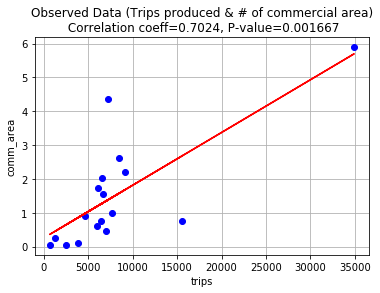

In [45]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["comm_area"], 'bo')
x = df["trips"]
y = df["comm_area"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('comm_area')
plt.title('Observed Data (Trips produced & # of commercial area)\n Correlation coeff=0.7024, P-value=0.001667')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

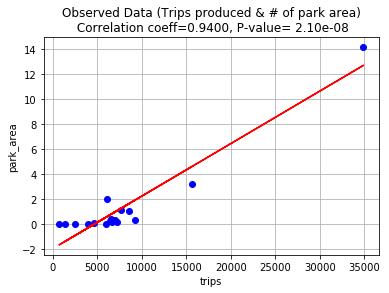

In [46]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["park_area"], 'bo')
x = df["trips"]
y = df["park_area"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('park_area')
plt.title('Observed Data (Trips produced & # of park area)\n Correlation coeff=0.9400, P-value= 2.10e-08')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

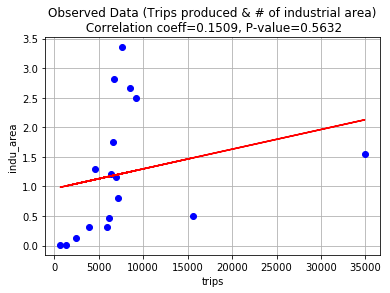

In [47]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["indu_area"], 'bo')
x = df["trips"]
y = df["indu_area"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('indu_area')
plt.title('Observed Data (Trips produced & # of industrial area)\n Correlation coeff=0.1509, P-value=0.5632')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

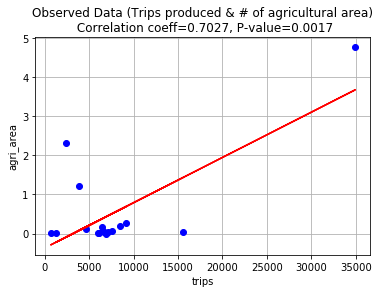

In [48]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["agri_area"], 'bo')
x = df["trips"]
y = df["agri_area"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('agri_area')
plt.title('Observed Data (Trips produced & # of agricultural area)\n Correlation coeff=0.7027, P-value=0.0017')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

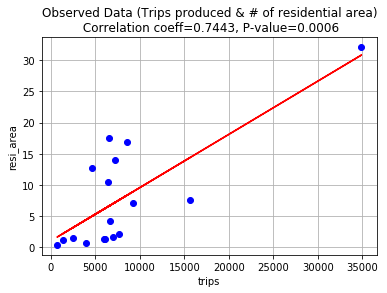

In [49]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["resi_area"], 'bo')
x = df["trips"]
y = df["resi_area"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('resi_area')
plt.title('Observed Data (Trips produced & # of residential area)\n Correlation coeff=0.7443, P-value=0.0006')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

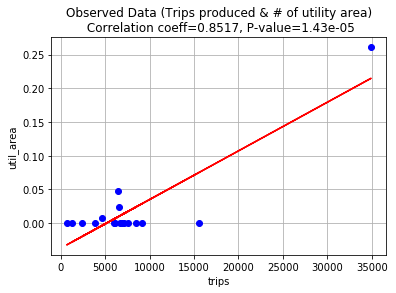

In [52]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["util_area"], 'bo')
x = df["trips"]
y = df["util_area"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('util_area')
plt.title('Observed Data (Trips produced & # of utility area)\n Correlation coeff=0.8517, P-value=1.43e-05')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

### Verify Collinearity through Scatter Plots

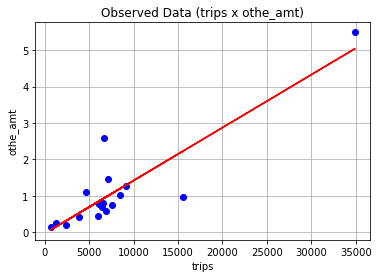

In [201]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["othe_amt"], 'bo')
x = df["trips"]
y = df["othe_amt"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('othe_amt')
plt.title('Observed Data (trips x othe_amt)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

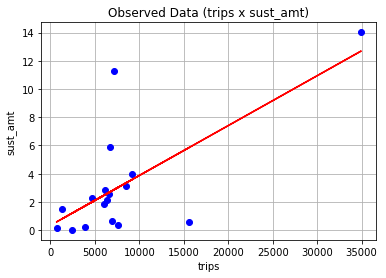

In [55]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["sust_amt"], 'bo')
x = df["trips"]
y = df["sust_amt"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('sust_amt')
plt.title('Observed Data (trips x sust_amt)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

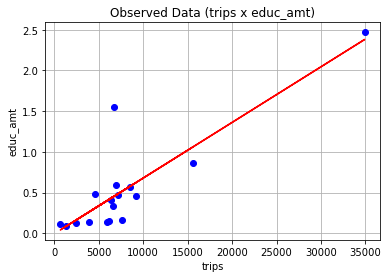

In [56]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["educ_amt"], 'bo')
x = df["trips"]
y = df["educ_amt"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('educ_amt')
plt.title('Observed Data (trips x educ_amt)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

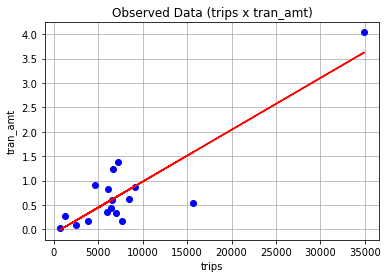

In [57]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["tran_amt"], 'bo')
x = df["trips"]
y = df["tran_amt"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('tran_amt')
plt.title('Observed Data (trips x tran_amt)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

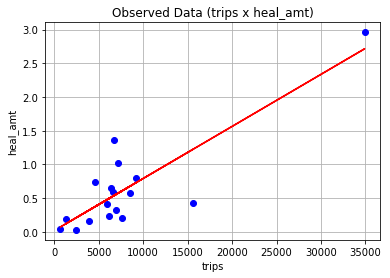

In [58]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["heal_amt"], 'bo')
x = df["trips"]
y = df["heal_amt"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('heal_amt')
plt.title('Observed Data (trips x heal_amt)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

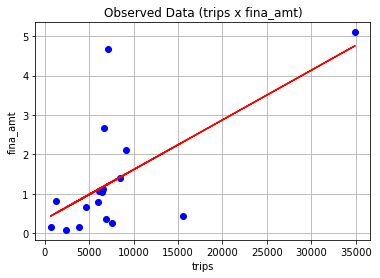

In [59]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["fina_amt"], 'bo')
x = df["trips"]
y = df["fina_amt"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('fina_amt')
plt.title('Observed Data (trips x fina_amt)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

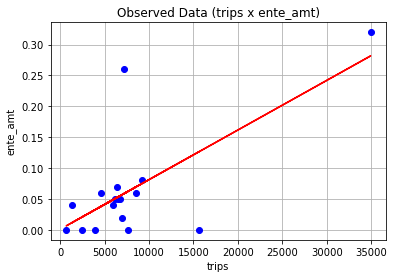

In [60]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["ente_amt"], 'bo')
x = df["trips"]
y = df["ente_amt"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('ente_amt')
plt.title('Observed Data (trips x ente_amt)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

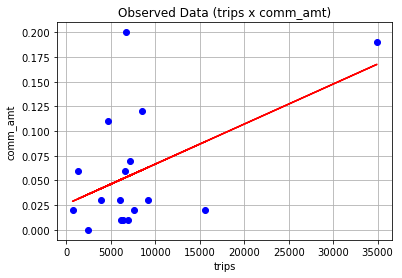

In [61]:
df = regression2.getDataFrame()
plt.plot(df["trips"], df["comm_amt"], 'bo')
x = df["trips"]
y = df["comm_amt"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('comm_amt')
plt.title('Observed Data (trips x comm_amt)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

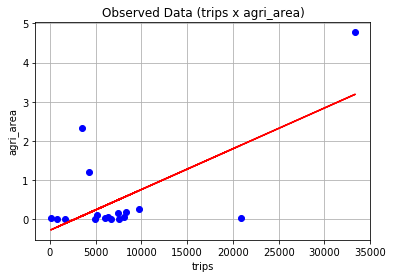

In [63]:
df = regression.getDataFrame()
plt.plot(df["trips"], df["agri_area"], 'bo')
x = df["trips"]
y = df["agri_area"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('agri_area')
plt.title('Observed Data (trips x agri_area)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

In [64]:
Collinearity between no_hh & trips = (0.92914760415527753, 7.1205170410730196e-08)
Collinearity between avg_income & trips = (0.91992035789848337, 1.7354578828442896e-07)
Collinearity between mem_no & trips = (0.91247798270778113, 3.305852610863916e-07)
Collinearity between no_mem_educwork & trips = (0.91764041951966036, 2.1277373172145904e-07)

SyntaxError: invalid syntax (<ipython-input-64-988561d38e77>, line 1)

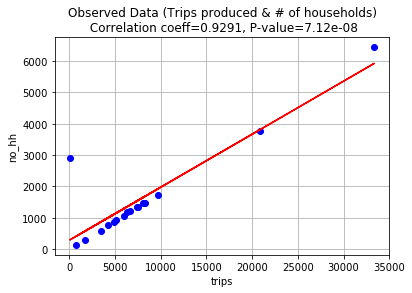

In [30]:
df = regression.getDataFrame()
plt.plot(df["trips"], df["no_hh"], 'bo')
x = df["trips"]
y = df["no_hh"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('no_hh')
plt.title('Observed Data (Trips produced & # of households)\n Correlation coeff=0.9291, P-value=7.12e-08')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

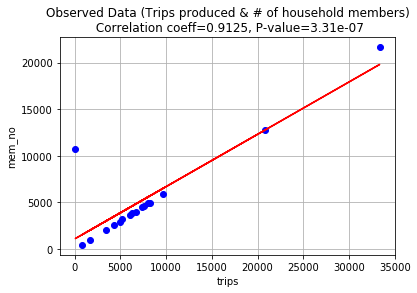

In [31]:
df = regression.getDataFrame()
plt.plot(df["trips"], df["mem_no"], 'bo')
x = df["trips"]
y = df["mem_no"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('mem_no')
plt.title('Observed Data (Trips produced & # of household members)\n Correlation coeff=0.9125, P-value=3.31e-07')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

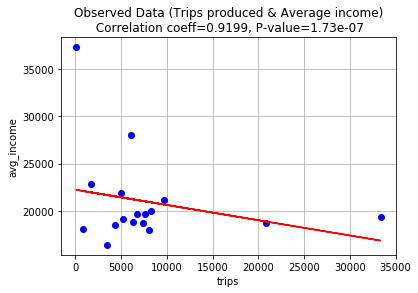

In [32]:
df = regression.getDataFrame()
plt.plot(df["trips"], df["avg_income"], 'bo')
x = df["trips"]
y = df["avg_income"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('avg_income')
plt.title('Observed Data (Trips produced & Average income)\n Correlation coeff=0.9199, P-value=1.73e-07')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

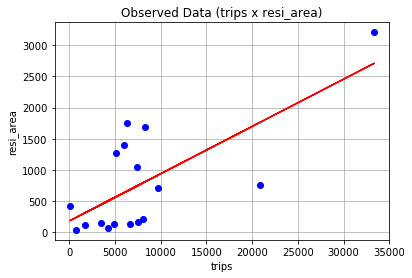

In [33]:
df = regression.getDataFrame()
plt.plot(df["trips"], df["resi_area"], 'bo')
x = df["trips"]
y = df["resi_area"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('resi_area')
plt.title('Observed Data (trips x resi_area)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

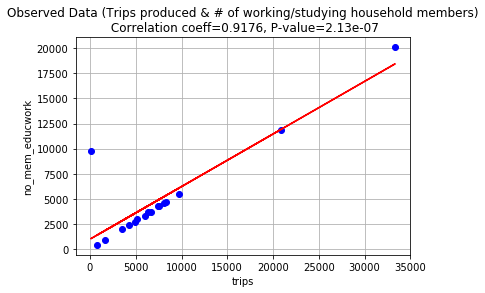

In [34]:
df = regression.getDataFrame()
plt.plot(df["trips"], df["no_mem_educwork"], 'bo')
x = df["trips"]
y = df["no_mem_educwork"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('trips')
plt.ylabel('no_mem_educwork')
plt.title('Observed Data (Trips produced & # of working/studying household members)\n Correlation coeff=0.9176, P-value=2.13e-07')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

In [29]:
df = regression.getDataFrame()
plt.plot(df["Trips"], df["Autos"], 'bo')
x = df["Trips"]
y = df["Autos"]
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.xlabel('Trips')
plt.ylabel('Establishments')
plt.title('Observed Data (TRIPS x AUTOS)')
plt.grid(True)
# plt.axis([0, 220, 0, 120])
plt.show()

KeyError: 'Trips'

# Generate table that contains the aggregated information per zone, given the TAZ input file and the Households input file (income, houses, # amenities of each kind)

#### Create TripGenTableModel:
wherein its attributes are the columns in the table example (Out 348, remove trips column, shape coordinate, landuse).

#### Get number of TAZs
#### Get number of landuse per TAZ
#### Create [ ][ ] of TripGenTableModel

#### SAMPLE CODE
TripGenTableModel tgtm = [# of TAZs][ ]
for n in range(0,len(TAZ)):
    LUShapes lus = getImpactingShapes(TAZ[n]) #Returns the whole shape coors of impacting landuses together with its category
    for x in range(0, len(lus)):
        tgtm[n][x] = new TripGenTableModel()
        tgtm[n][x].setShapeCoordinate(TAZ[n], lus[x]) #sets a coor shape for the overlapping of the TAZ shape and landuse shape
        
for cbms_file in cmbs_files:
    for row in cbms_file:
        lat, long = getCoor(row)
        add_info_to_respective_TGTM(lat, long, row) #adds the info of the HH to the correct zone and landuse
        
        
        
        



# Detemine landuse of each zone using the land use file

# Get the corresponding trip productions and attractions per zone given the parameters

# MODEL FITTING

### Retreival of intercepts and coefficients
**Features for Trip production**: # of HH, # of HH members, # of employed, # of enrolled, Income, Landuse and Amenity Data

**Features for Trip attraction**: # of Establishments, # of working in area, # of enrolled in area, Landuse and Amenity Data

In [39]:
dep_col_name = "trips"
data_filepath = "DummyDataRegression.csv"
regression = Regression(data_filepath)

data_filepath2 = "DummyDataRegressionAmenitiex.csv"
regression2 = Regression(data_filepath2)

selected_feature_names = ["no_hh","avg_income","mem_no"]
selected_feature_names_attraction = ["sust_amt","educ_amt","tran_amt","heal_amt","fina_amt","comm_amt", "ente_amt","othe_amt",
                        "comm_area", "park_area","indu_area","agri_area","resi_area","util_area","othe_area"]
fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)
fitted_production_model_attr = regression2.getFittedRegressionModel(selected_feature_names_attraction, dep_col_name)

print("Prod Intercept:"+str(fitted_production_model.intercept_)+" Coef:"+str(fitted_production_model.coef_))
print("Attr Intercept:"+str(fitted_production_model_attr.intercept_)+" Coef:"+str(fitted_production_model_attr.coef_))

dummy_data = pd.read_csv('DummyDataRegressionHHTripsOnly.csv', index_col=0)
dummy_data.head()

R^2 score: 0.987350266174
R^2 score: 0.996911644387
Prod Intercept:344.745174492 Coef:[ 85.04687743   3.36621094 -26.75217765]
Attr Intercept:4805.98183877 Coef:[  -49.6028897     -4.83505864  -154.53369632   312.99534481    19.79017006
  -980.65529731  1164.01053445    58.86796291    13.15743504    81.67469428
   -14.09065401    10.80746015     6.22225556 -3549.39096573     0.        ]


,no_hh,avg_income,mem_no,no_mem_educwork,trips
1,3779,18736.43821,12747,11894,37428
2,1349,18754.63306,4509,4238,14213
3,1060,28070.75472,3624,3321,13730
4,767,18507.17080,2598,2402,8437
5,862,21937.35499,2913,2720,11306


In [31]:
print(selected_feature_names)
X_vals = regression.getXVals(selected_feature_names)
Y_vals = regression.getYVals(dep_col_name)

for x in range(len(X_vals.index)):
    Predicted_vals = []
    print("Test row: "+str(x))
    fitted_production_model2 = regression.kFoldTest(selected_feature_names, dep_col_name, x);
    #testdframe.head()
    #fitted_production_model2.predict(X_vals.iloc[x , :].values.reshape(1,-1))
    for z in range(len(X_vals.index)):
        #print("Actual Zone "+str(z)+": "+str(Y_vals.iloc[z]))
        #print("Predicted Zone "+str(z)+": "+str(fitted_production_model2.predict(X_vals.iloc[z , :].values.reshape(1,-1))[0]))
        Predicted_vals.append(fitted_production_model2.predict(X_vals.iloc[z , :].values.reshape(1,-1))[0])
    rms = sqrt(mean_squared_error(Y_vals.values, Predicted_vals))
    print("Trained using index "+str(x)+": RMS = "+str(rms))

['no_hh', 'avg_income', 'mem_no', 'no_mem_educwork']
Test row: 0
Trained using index 0: RMS = 1642.8611353042031
Test row: 1
Trained using index 1: RMS = 1623.0075678854153
Test row: 2
Trained using index 2: RMS = 1613.9679788752348
Test row: 3
Trained using index 3: RMS = 1626.248724401083
Test row: 4
Trained using index 4: RMS = 1598.2276558902588
Test row: 5
Trained using index 5: RMS = 5983.535008027696
Test row: 6
Trained using index 6: RMS = 1604.1427427182311
Test row: 7
Trained using index 7: RMS = 1601.8320898685502
Test row: 8
Trained using index 8: RMS = 1641.223576273628
Test row: 9
Trained using index 9: RMS = 1614.0143609756592
Test row: 10
Trained using index 10: RMS = 1651.3620291500129
Test row: 11
Trained using index 11: RMS = 1615.7890835165513
Test row: 12
Trained using index 12: RMS = 1597.9605414533635
Test row: 13
Trained using index 13: RMS = 2396.378970999385
Test row: 14
Trained using index 14: RMS = 1598.4290560976747
Test row: 15
Trained using index 15: RMS 

In [32]:
rms = sqrt(mean_squared_error(Y_vals.values, Predicted_vals))
rms

1606.6848114811119

In [120]:
dep_col_name = "trips"
data_filepath = "DummyDataRegression.csv"
regression = Regression(data_filepath)

data_filepath2 = "DummyDataRegressionAmenitiex.csv"
regression2 = Regression(data_filepath2)

selected_feature_names = ["mem_no"]
selected_feature_names_attraction = ["sust_amt","educ_amt","tran_amt","heal_amt","fina_amt","comm_amt", "ente_amt","othe_amt",
                        "comm_area", "park_area","indu_area","agri_area","resi_area","util_area","othe_area"]
fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)
fitted_production_model_attr = regression2.getFittedRegressionModel(selected_feature_names_attraction, dep_col_name)

print("Prod Intercept:"+str(fitted_production_model.intercept_)+" Coef:"+str(fitted_production_model.coef_))
print("Attr Intercept:"+str(fitted_production_model_attr.intercept_)+" Coef:"+str(fitted_production_model_attr.coef_))

dummy_data = pd.read_csv('DummyDataRegression.csv', index_col=0)
dummy_data.head()

R^2 score: 0.832616068926
R^2 score: 0.996911644387
Prod Intercept:645.860276196 Coef:[ 2.81864012]
Attr Intercept:4805.98183877 Coef:[  -49.6028897     -4.83505864  -154.53369632   312.99534481    19.79017006
  -980.65529731  1164.01053445    58.86796291    13.15743504    81.67469428
   -14.09065401    10.80746015     6.22225556 -3549.39096573     0.        ]


,no_hh,avg_income,mem_no,no_mem_educwork,comm_area,park_area,indu_area,agri_area,resi_area,util_area,othe_area,trips
1,3779,17110,12747,11894,63.27,267.37,41.97,3.23,628.96,0.00,0,37428
2,1349,6272,4509,4238,63.89,23.96,100.79,13.46,880.06,3.99,0,14213
3,1060,5670,3624,3321,363.71,17.29,67.77,3.86,1171.00,0.00,0,13093
4,767,3390,2598,2402,9.29,1.26,26.27,101.10,55.95,0.00,0,8437
5,862,4271,2913,2720,50.37,0.00,26.36,1.25,114.65,0.00,0,9969


In [24]:
print(selected_feature_names)
X_vals = regression.getXVals(selected_feature_names)
Y_vals = regression.getYVals(dep_col_name)

for x in range(len(X_vals.index)):
    Predicted_vals = []
    print("Test row: "+str(x))
    fitted_production_model2 = regression.kFoldTest(selected_feature_names, dep_col_name, x);
    #testdframe.head()
    #fitted_production_model2.predict(X_vals.iloc[x , :].values.reshape(1,-1))
    for z in range(len(X_vals.index)):
        #print("Actual Zone "+str(z)+": "+str(Y_vals.iloc[z]))
        #print("Predicted Zone "+str(z)+": "+str(fitted_production_model2.predict(X_vals.iloc[z , :].values.reshape(1,-1))[0]))
        Predicted_vals.append(fitted_production_model2.predict(X_vals.iloc[z , :].values.reshape(1,-1))[0])
    rms = sqrt(mean_squared_error(Y_vals.values, Predicted_vals))
    print("Trained using index "+str(x)+": RMS = "+str(rms))

['no_hh', 'avg_income', 'mem_no', 'no_mem_educwork', 'comm_area', 'park_area', 'indu_area', 'agri_area', 'resi_area', 'util_area', 'othe_area']
Test row: 0
Trained using index 0: RMS = 1513.8400745835781
Test row: 1
Trained using index 1: RMS = 1750.189584314592
Test row: 2
Trained using index 2: RMS = 1156.465665211328
Test row: 3
Trained using index 3: RMS = 1206.031396848907
Test row: 4
Trained using index 4: RMS = 1161.20530774799
Test row: 5
Trained using index 5: RMS = 6472.118807400362
Test row: 6
Trained using index 6: RMS = 1260.61796218028
Test row: 7
Trained using index 7: RMS = 1173.0711517046389
Test row: 8
Trained using index 8: RMS = 1736.3256089725148
Test row: 9
Trained using index 9: RMS = 1258.9239107597048
Test row: 10
Trained using index 10: RMS = 1349.430196341538
Test row: 11
Trained using index 11: RMS = 1313.8326517895605
Test row: 12
Trained using index 12: RMS = 1179.1122567101238
Test row: 13
Trained using index 13: RMS = 11791.146640090681
Test row: 14
Trai

In [25]:
print(selected_feature_names)
X_vals = regression.getXVals(selected_feature_names)
Y_vals = regression.getYVals(dep_col_name)
Predicted_vals = []
for x in range(len(X_vals.index)):
    
    print("Test row: "+str(x))
    fitted_production_model2 = regression.kFoldTest(selected_feature_names, dep_col_name, x);
    #testdframe.head()
    #fitted_production_model2.predict(X_vals.iloc[x , :].values.reshape(1,-1))
    #fitted
    print("Actual Zone "+str(x)+": "+str(Y_vals.iloc[x]))
    print("Predicted Zone "+str(x)+": "+str(fitted_production_model2.predict(X_vals.iloc[x , :].values.reshape(1,-1))[0]))
    Predicted_vals.append(fitted_production_model2.predict(X_vals.iloc[x , :].values.reshape(1,-1))[0])

['no_hh', 'avg_income', 'mem_no', 'no_mem_educwork', 'comm_area', 'park_area', 'indu_area', 'agri_area', 'resi_area', 'util_area', 'othe_area']
Test row: 0
Actual Zone 0: 37428
Predicted Zone 0: 41583.8900525
Test row: 1
Actual Zone 1: 14213
Predicted Zone 1: 20711.7925161
Test row: 2
Actual Zone 2: 13093
Predicted Zone 2: 12798.5943355
Test row: 3
Actual Zone 3: 8437
Predicted Zone 3: 6403.17213939
Test row: 4
Actual Zone 4: 9969
Predicted Zone 4: 9057.55220162
Test row: 5
Actual Zone 5: 6779
Predicted Zone 5: 33417.09022
Test row: 6
Actual Zone 6: 10373
Predicted Zone 6: 7287.32105234
Test row: 7
Actual Zone 7: 13713
Predicted Zone 7: 14781.5778026
Test row: 8
Actual Zone 8: 6084
Predicted Zone 8: 12138.1679747
Test row: 9
Actual Zone 9: 17149
Predicted Zone 9: 19700.7350103
Test row: 10
Actual Zone 10: 13107
Predicted Zone 10: 17188.0208826
Test row: 11
Actual Zone 11: 19694
Predicted Zone 11: 16024.5765148
Test row: 12
Actual Zone 12: 1542
Predicted Zone 12: 2929.74082313
Test row:

In [26]:
rms = sqrt(mean_squared_error(Y_vals.values, Predicted_vals))
rms

13789.642839207072

In [27]:
fitted_production_model2, testdframe = regression.kFoldTest(selected_feature_names, dep_col_name, 1)
X_vals = regression.getXVals(selected_feature_names)
testdframe.head()
fitted_production_model2.predict(X_vals.loc[1 , :])

TypeError: 'LinearRegression' object is not iterable

### Prediction of Trip Production & Attraction using the intercepts and coefficients

In [ ]:
trip_gen = TripGeneration("DummyDataRegressionFused.csv", "trips")
prod_col_names = selected_feature_names
attr_col_names = selected_feature_names_attraction
trip_gen.setProductionParameters(prod_col_names, fitted_production_model.intercept_, fitted_production_model.coef_)
trip_gen.setAttractionParameters(attr_col_names, fitted_production_model_attr.intercept_, fitted_production_model_attr.coef_)
print("Example:")
print("Overall Trip Production: "+str(trip_gen.getWholeTripProductionScore()))
print("Overall Trip Attraction: "+str(trip_gen.getWholeTripAttractionScore()))

### Computing for Trip Balancing Factor

In [ ]:
trip_gen.doTripBalancing()
print("Balancing Factor: "+str(trip_gen.getBalancingFactor()))


### Zonal-level Trip Production & Attraction Scores

In [ ]:
zonal_df, productions, attractions = trip_gen.printAllZonalTripsProductionAttraction()
display(zonal_df)

# Model Validation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)
X_digits = regression.getSubTable(selected_feature_names)
Y_digits = regression.getSubTable(dep_col_name)
scores = cross_validation.cross_val_score(fitted_production_model, X_digits, Y_digits, scoring='r2', cv=10,)
#X_digits.shape, Y_digits.shape
scores

# MODEL OUTPUT

# Trip Distribution Class

In [ ]:
class TripDistribution:

    def __init__(self, productions, attractions):
        self.productions = productions
        self.attractions = attractions
        self.row = len(productions)
        self.col = len(attractions)
        self.possibleError = 3
        self.error = 0

    def getGeneralizedCost(self, cost):
        return 1.0 / (cost * cost)

    def getTripDistribution(self):
        distributions = [[self.attractions[y] for x in range(self.row)] for y in range(self.col)]
        costMatrix = [[1 for x in range(self.row)] for y in range(self.col)]
        #costMatrix = [[1.0, 1.2, 1.8], [1.2, 1.0, 1.5], [1.8, 1.5, 1.0]]
        A = [1 for x in range(self.row)]
        B = [1 for x in range(self.col)]

        currentBalancingFactor = 0  # 0 for A, 1 for B
        isConvergent = False

        while isConvergent == False:
            if currentBalancingFactor == 0:
                A = self.computeA(B, costMatrix)
                currentBalancingFactor = 1
            elif currentBalancingFactor == 1:
                B = self.computeB(A, costMatrix)
                currentBalancingFactor = 0
            distributions = self.computeDistributions(A, B, costMatrix)
            isConvergent = self.checkIfConvergent(distributions)
        return distributions

    def computeDistributions(self, A, B, costMatrix):
        distributions = [[self.attractions[y] for x in range(self.row)] for y in range(self.col)]
        for x in range(self.row):
            for y in range(self.col):
                distributions[x][y] = A[x] * self.productions[x] * B[y] * self.attractions[y] * self.getGeneralizedCost(costMatrix[x][y])
        return distributions

    def checkIfConvergent(self, distributions):
        error = self.getError(distributions)
        if error <= self.possibleError:
            self.error = error
            return True
        return False

    def getError(self, distributions):
        error = 0
        derivedProductions = [0 for x in range(self.row)]
        derivedAttractions = [0 for x in range(self.col)]

        for x in range(self.row):
            for y in range(self.col):
                derivedProductions[x] += distributions[x][y]
                derivedAttractions[y] += distributions[x][y]

        for x in range(self.row):
            error += abs(derivedProductions[x] - self.productions[x])
            error += abs(derivedAttractions[y] - self.attractions[y])

        return error

    def computeA(self, B, costMatrix):
        A = [1 for x in range(self.row)]
        for x in range(0, self.row):
            sum = 0.0
            for y in range(0, self.col):
                sum += B[y] * self.attractions[y] * self.getGeneralizedCost(costMatrix[x][y])
            A[x] = 1.0 / sum
        return A

    def computeB(self, A, costMatrix):
        B = [1 for x in range(self.col)]
        for x in range(0, self.row):
            sum = 0.0
            for y in range(0, self.col):
                sum += A[y] * self.productions[y] * self.getGeneralizedCost(costMatrix[x][y])
            B[x] = 1.0 / sum
        return B

# Data

## The result from trip generation (trip production and attraction) will be passed to trip distribution

In [ ]:
td = TripDistribution(productions, attractions)

#pandas_distrib = pd.DataFrame(td, columns=('1','2'))

#print("Productions: " + str(productions))
#print("Attractions: " + str(attractions))

In [ ]:
distribution = td.getTripDistribution()

pandas_distrib = pd.DataFrame(distribution, columns=range(0,len(productions)))

# pandas_distrib.head()
display(HTML(
    '<table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in distribution)
        )
))

# Error

In [ ]:
print("Error: " + str(td.error))

# Modal Split Class

In [ ]:
import random
class ModalSplit:

    def __init__(self, od_matrix, pathToData):
        self.od_matrix = od_matrix
        self.pathToData = pathToData
        self.travel_costs = []
        self.travel_probabilities = []
        self.modes = ['jeep','bus','train']
        
    def computeGeneralizedCosts(self, zone_number):
        #data = pd.read_csv(self.pathToData, index_col=0)
        self.travel_costs = [None] * len(self.modes)
        for x in range(0, len(self.modes)):
            self.travel_costs[x] = random.randrange(1,4)
            
        #Compute for generalized cost for each mode for this specific zone
        # populate self.travel_costs with the travel costs
        self.computeModalProbabilities()
        
    def computeModalProbabilities(self):
        self.travel_probabilities = [None] * len(self.modes)
        sum = 0
        #print(len(self.travel_costs))
        for x in range(0,3):
            sum += exp(-self.travel_costs[x])
        for x in range(0,3):
            self.travel_probabilities[x] = exp(-self.travel_costs[x])/sum
        #print(self.travel_costs)
        #print(self.travel_probabilities)
    
    def getPartitionedTripsByMode(self, total_trips):
        return total_trips*self.travel_probabilities[0], self.travel_probabilities[1], self.travel_probabilities[2]
    
    def process_od_matrix(self):
        #print("size:"+str(len(self.od_matrix))+","+str(len(self.od_matrix[0])))
        #df = DataFrame(columns=('lib', 'qty1', 'qty2'))
        #for i in range(5):
            #df.loc[i] = [randint(-1,1) for n in range(3)]
        cols = list(range(len(self.od_matrix[0])))
        df_list = []
        for x in range(0, len(self.modes)):
            df = pd.DataFrame(columns=cols) 
            df_list.append(df)
            
        for y in range(0, len(self.od_matrix)):
            self.computeGeneralizedCosts(y)
            for z in range(0, len(self.modes)):
                od_row = []
                for x in range(0, len(self.od_matrix[0])):
                    #print("x:"+str(x)+" y:"+str(y)+" z:"+str(z))
                    od_row.append(round(self.od_matrix[x][y]*self.travel_probabilities[z],2))
                df_list[z].loc[y] = od_row
                
        return df_list
                

In [ ]:
modal_split = ModalSplit(distribution,"datapath")
list_of_dataframes_by_mode = modal_split.process_od_matrix()

## Mode 1

In [ ]:
display(list_of_dataframes_by_mode[0])

## Mode 2

In [ ]:
display(list_of_dataframes_by_mode[1])

## Mode 3

In [71]:
display(list_of_dataframes_by_mode[2])

NameError: name 'list_of_dataframes_by_mode' is not defined

In [143]:
selected_feature_names = ["no_hh","avg_income","mem_no","no_mem_educwork",
                        "comm_area", "park_area","indu_area","agri_area","resi_area","util_area","othe_area"]
dep_col_name = "trips"
data_filepath = "DummyDataRegression_revised_2.csv"
array = pd.read_csv(data_filepath, index_col=0)
X = array.loc[:, selected_feature_names]
Y = array.loc[:, dep_col_name]


selected_feature_names2 = ["sust_amt","educ_amt","tran_amt","heal_amt","fina_amt","comm_amt", "ente_amt","othe_amt",
                        "comm_area", "park_area","indu_area","agri_area","resi_area","util_area","othe_area"]
dep_col_name2 = "trips"
data_filepath2 = "DummyDataRegressionAmenitiex_revised_2.csv"
array2 = pd.read_csv(data_filepath2, index_col=0)
X2 = array2.loc[:, selected_feature_names2]
Y2 = array2.loc[:, dep_col_name2]

In [117]:
from sklearn.linear_model import Lasso
lin = Lasso(alpha=0.0001,precompute=True,max_iter=10000000,
            positive=True, random_state=9999, selection='random')
model = lin.fit(X2,Y2)
print("coef_: "+str(model.coef_))
print("intercept_: "+str(model.intercept_))

coef_: [    0.             0.           885.76908737    60.29160405     0.             0.
     0.             6.9591418   1876.26286501   844.92558909     0.
    56.14005775     0.             0.        ]
intercept_: 3201.21229873


## FOR TRIP GENERATION EXPERIMENTS
Use this section to test trip tripgeneration

In [309]:
selected_feature_names = ["no_hh","mem_no","no_mem_educwork",
                        "comm_area", "park_area","indu_area","agri_area","resi_area","util_area","othe_area"]
dep_col_name = "trips"
data_filepath = "DummyDataRegression_revised_2.csv"
array = pd.read_csv(data_filepath, index_col=0)
X = array.loc[:, selected_feature_names]
Y = array.loc[:, dep_col_name]


selected_feature_names2 = ["sust_amt","educ_amt","tran_amt","heal_amt","fina_amt","comm_amt", "ente_amt","othe_amt",
                        "comm_area", "park_area","indu_area","agri_area","resi_area","util_area","othe_area"]
dep_col_name2 = "trips"
data_filepath2 = "DummyDataRegressionAmenitiex_revised_2.csv"
array2 = pd.read_csv(data_filepath2, index_col=0)
X2 = array2.loc[:, selected_feature_names2]
Y2 = array2.loc[:, dep_col_name2]

fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)
fitted_production_model_attr = regression2.getFittedRegressionModel(selected_feature_names2, dep_col_name2)

#print("Prod Intercept:"+str(fitted_production_model.intercept_)+" Coef:"+str(fitted_production_model.coef_))
#print("Attr Intercept:"+str(fitted_production_model_attr.intercept_)+" Coef:"+str(fitted_production_model_attr.coef_))
#print(fitted_production_model.coef_)


R^2 score: 0.989666973118
R^2 score: 0.996974590791


In [310]:
from scipy.sparse import rand
from scipy.optimize import lsq_linear
import sys

A = np.array(X.values)
b = np.array(Y.values)
res = lsq_linear(A, b, bounds=(0, 600), lsmr_tol='auto', verbose=1)
print(res['x'])
#[ 85.04687743   3.36621094 -26.75217765]

The relative change of the cost function is less than `tol`.
Number of iterations 17, initial cost 2.8981e+12, final cost 8.3290e+07, first-order optimality 3.67e-05.
[  3.29147761e+00   2.08982787e-20   5.28792145e-22   5.61467426e-19
   6.00000000e+02   4.40542048e-20   1.94194107e-14   1.55278782e+02
   4.20451846e-21   1.00000000e-01]


In [311]:
from scipy.sparse import rand
from scipy.optimize import lsq_linear
import sys

A = np.array(X2.values)
b = np.array(Y2.values)
res2 = lsq_linear(A, b, bounds=(0, 1100), lsmr_tol='auto', verbose=1)
print(res2['x'])
#[ 85.04687743   3.36621094 -26.75217765]

The relative change of the cost function is less than `tol`.
Number of iterations 12, initial cost 1.8900e+08, final cost 6.0515e+07, first-order optimality 1.68e-07.
[  2.54890477e-15   1.10000000e+03   1.30374385e+02   1.75348756e+02
   7.35037140e-15   1.36839648e-19   2.27627021e-14   1.10000000e+03
   3.99399310e+02   1.10000000e+03   1.10000000e+03   3.42146846e+02
   1.55961256e+02   3.70819319e-17   1.00000000e-01]


## Trip Production Experiment:
Change the values after "fitted_production_model.predict(["

In [90]:
#x4 x1.16
#3.37 0.74
#fitted_production_model.predict([73444,252283.04,294170,189034,3.74E-05,3.06E-05,9.67E-05,0,0.000137578,0,0])[0]
#36088
#print(fitted_production_model.intercept_)
#fitted_production_model.coef_= res['x']
fitted_production_model.coef_ = res['x']
fitted_production_model.intercept_ = 0
#print(fitted_production_model.coef_)
fitted_production_model.predict([ 
 
 
73444,
21023.5866,
294170,
189034,
    3.74E-05,
    3.06E-05,9.67E-05,0,0.000137578,0,0




])[0]

C:\Users\xtiangabe\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


223676.3835724805

## Trip Attraction Experiment:
Change the values after "fitted_production_model_attr.predict(["

In [ ]:
#x4 x1.16
#3.37 0.74
#fitted_production_model.predict([73444,252283.04,294170,189034,3.74E-05,3.06E-05,9.67E-05,0,0.000137578,0,0])[0]
#36088
fitted_production_model_attr.coef_ = res2['x']
#print(res2['x'])
fitted_production_model_attr.intercept_ = 0
fitted_production_model_attr.predict([ 
214,41,43,65,104,1,7,68,76.58437814,28.72281707,120.8066626,16.13752741,1054.76527,4.793359305,0





])[0]

## Additional regression info:

In [287]:
dep_col_name = "trips"
data_filepath = "DummyDataRegression_revised_2.csv"
regression = Regression(data_filepath)

data_filepath2 = "DummyDataRegressionAmenitiex_revised_2.csv"
regression2 = Regression(data_filepath2)

selected_feature_names = ["no_hh","mem_no","no_mem_educwork", "comm_area", "park_area","indu_area","agri_area","resi_area","util_area","othe_area"]
selected_feature_names_attraction = ["sust_amt","educ_amt","tran_amt","heal_amt","fina_amt","comm_amt", "ente_amt","othe_amt",
                        "comm_area", "park_area","indu_area","agri_area","resi_area","util_area","othe_area"]
result = regression.statsmodelsRegressionSummary(selected_feature_names, dep_col_name)

result.summary()

C:\Users\xtiangabe\Anaconda3\lib\site-packages\scipy\stats\stats.py:1327: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
C:\Users\xtiangabe\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1471: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\Users\xtiangabe\Anaconda3\lib\site-packages\statsmodels\base\model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\xtiangabe\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\xtiangabe\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\xtiangabe\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1814: RuntimeWarning: i

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  trips   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     174.5
Date:                Sat, 08 Jul 2017   Prob (F-statistic):           3.27e-08
Time:                        02:30:43   Log-Likelihood:                -137.55
No. Observations:                  17   AIC:                             293.1
Df Residuals:                       8   BIC:                             300.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
no_hh              24.7675     19.037      1.301      0.229     -19.132      68.667
mem_no            -38.8308     11.335     -3.426      0.009     -64.970     -12.692
no_mem_educwork    35.6160     17.694      2.013      0.079      -5.187      76.419
comm_area         915.1899    537.080      1.704      0.127    -323.320    2153.700
park_area        -340.1403    464.075     -0.733      0.485   -1410.299     730.019
indu_area        -529.1575    344.893     -1.534      0.164   -1324.482     266.167
agri_area         342.7467    458.536      0.747      0.476    -714.640    1400.134
resi_area         -95.4159    101.792     -0.937      0.376    -330.148     139.317
util_area       -2000.1525   2.01e+04     -0.100      0.923   -4.83e+04    4.43e+04
othe_area                0          0        nan        nan           0           0
==============================================================================
Omnibus:                        3.728   Durbin-Watson:                   2.208
Prob(Omnibus):                  0.155   Jarque-Bera (JB):                2.379
Skew:                           0.916   Prob(JB):                        0.304
Kurtosis:                       2.981   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## K-fold validation (6-fold) and measuring by % RMSE values

In [288]:
totalrmse = 0
print(selected_feature_names)
X_vals = regression.getXVals(selected_feature_names)
Y_vals = regression.getYVals(dep_col_name)
regression.kFoldTest2(selected_feature_names, dep_col_name, 1)


['no_hh', 'mem_no', 'no_mem_educwork', 'comm_area', 'park_area', 'indu_area', 'agri_area', 'resi_area', 'util_area', 'othe_area']
The relative change of the cost function is less than `tol`.
Number of iterations 18, initial cost 2.4089e+12, final cost 5.7725e+07, first-order optimality 2.01e-05.
pred: 11016.4241154
Trained using slice 0: RawRMSE=9846.57588458824 %RMSE=47.1963566342
The relative change of the cost function is less than `tol`.
Number of iterations 17, initial cost 3.9599e+12, final cost 8.2602e+07, first-order optimality 1.48e-02.
pred: 6174.20376365
Trained using slice 1: RawRMSE=1214.7962363466759 %RMSE=16.4406040918
The relative change of the cost function is less than `tol`.
Number of iterations 21, initial cost 2.8270e+12, final cost 8.3251e+07, first-order optimality 1.56e-05.
pred: 5749.11566601
Trained using slice 2: RawRMSE=300.8843339865325 %RMSE=4.97329477664
The relative change of the cost function is less than `tol`.
Number of iterations 18, initial cost 3.2

In [30]:
#x4 x1.16
#3.37 0.74
#fitted_production_model.predict([73444,252283.04,294170,189034,3.74E-05,3.06E-05,9.67E-05,0,0.000137578,0,0])[0]
#36088
#print(fitted_production_model.intercept_)
#fitted_production_model.coef_= res['x']
fitted_production_model.coef_ = res['x']
fitted_production_model.intercept_ = 0
print(fitted_production_model.coef_)
fitted_production_model.predict([ 
 
3779,
17110,
12747,
11894,
63.27,
267.37,
41.97,
3.23,
628.96,
0,
0

])[0]

[  3.04156366e+00   1.38767539e-02   1.55423723e-22   1.84297629e-27
   2.51584060e-23   7.44158844e+02   7.07666514e-17   9.76073097e-19
   1.44405803e+02   4.69102139e-20   1.00000000e-01]


C:\Users\xtiangabe\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


301522.7242228887

In [ ]:
#x4 x1.16
#3.37 0.74
#fitted_production_model.predict([73444,252283.04,294170,189034,3.74E-05,3.06E-05,9.67E-05,0,0.000137578,0,0])[0]
#36088
fitted_production_model_attr.coef_ = res2['x']
print(res2['x'])
fitted_production_model_attr.intercept_ = 0
fitted_production_model_attr.predict([ 
 58,
86,
54,
43,
44,
2,
20,
97,
63.27,
267.37,
41.97,
3.23,
628.96,
0,
0

])[0]

## K-fold validation (17-fold)

In [ ]:
regression.kFoldTest2(selected_feature_names, dep_col_name, 1);

### 2.) with LANDUSE variables

In [ ]:
dummy_data = pd.read_csv('DummyDataRegression.csv', index_col=0)
dummy_data.head()

In [ ]:
regression.kFoldTest2(["no_hh","avg_income","mem_no","no_mem_educwork"], dep_col_name, 1)

In [ ]:
regression.kFoldTest2(['no_hh', 'avg_income', 'mem_no', 'agri_area', 'resi_area', 'util_area'], dep_col_name, 1)

In [ ]:

        
dep_col_name = "trips"
data_filepath = "DummyDataRegression.csv"
regression = Regression(data_filepath)
original_df  =  pd.read_csv(data_filepath, index_col=0)
data_filepath2 = "DummyDataRegressionAmenitiex.csv"
regression2 = Regression(data_filepath2)

selected_feature_names_attraction = ["sust_amt","educ_amt","tran_amt","heal_amt","fina_amt","comm_amt", "ente_amt","othe_amt",
                        "comm_area", "park_area","indu_area","agri_area","resi_area","util_area","othe_area"]
#fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)
#fitted_production_model_attr = regression2.getFittedRegressionModel(selected_feature_names_attraction, dep_col_name)
##

selected_feature_names = ["no_hh","avg_income","mem_no","no_mem_educwork"]
landuse_names = ["comm_area","park_area", "indu_area","agri_area",
                         "resi_area", "util_area"]
totalrmse = 0
print(selected_feature_names)
X_vals = regression.getXVals(selected_feature_names+landuse_names)
Y_vals = regression.getYVals(dep_col_name)
best_comb = []
best_score = 0
initialized = False

for L in range(1, len(selected_feature_names+landuse_names)+1):
  for subset in itertools.combinations(selected_feature_names+landuse_names, L):
    curr_cols = list(subset)
    print("current: "+str(curr_cols))
    totalrmse = 0
    rms = regression.kFoldTest3(curr_cols, dep_col_name, 3)
    totalrmse += rms
    #print("Trained using index "+str(x)+": RMSE = "+str(rms))
    print("TOTAL RMSE: "+str(totalrmse))
    if(initialized == False):
        best_score = totalrmse
        initialized = True 
        best_comb = curr_cols
    else:
        if(totalrmse < best_score):
            best_score = totalrmse
            best_comb = curr_cols
print("\n \nBest Score: "+str(best_score))
print("Best Combination: "+str(best_comb))      
        

In [ ]:
dep_col_name = "trips"
data_filepath = "DummyDataRegression.csv"
regression = Regression(data_filepath)
original_df  =  pd.read_csv(data_filepath, index_col=0)
data_filepath2 = "DummyDataRegressionAmenitiex.csv"
regression2 = Regression(data_filepath2)

selected_feature_names_attraction = ["sust_amt","educ_amt","tran_amt","heal_amt","fina_amt","comm_amt", "ente_amt","othe_amt",
                        "comm_area", "park_area","indu_area","agri_area","resi_area","util_area","othe_area"]
#fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)
#fitted_production_model_attr = regression2.getFittedRegressionModel(selected_feature_names_attraction, dep_col_name)
##

selected_feature_names = ["no_hh","avg_income","mem_no","no_mem_educwork"]
landuse_names = ["comm_area","park_area", "indu_area","agri_area",
                         "resi_area", "util_area"]
totalrmse = 0
print(selected_feature_names)
X_vals = regression.getXVals(selected_feature_names+landuse_names)
Y_vals = regression.getYVals(dep_col_name)
best_comb = []
best_score = 0
initialized = False

for L in range(1, len(selected_feature_names+landuse_names)+1):
  for subset in itertools.combinations(selected_feature_names+landuse_names, L):
    curr_cols = list(subset)
    print("current: "+str(curr_cols))
    totalrmse = 0
    for x in range(len(X_vals.index)):
        Predicted_vals = []
        #print("Test row: "+str(x))
        fitted_production_model2 = regression.kFoldTest(curr_cols, dep_col_name, x);
        #testdframe.head()
        #fitted_production_model2.predict(X_vals.iloc[x , :].values.reshape(1,-1))
        for z in range(len(X_vals.index)):
            #print("Actual Zone "+str(z)+": "+str(Y_vals.iloc[z]))
            #print("Predicted Zone "+str(z)+": "+str(fitted_production_model2.predict(X_vals.iloc[z , :].values.reshape(1,-1))[0]))
            #print("subset"+str(list(subset)))
            Predicted_vals.append(fitted_production_model2.predict(X_vals.iloc[z , :].loc[curr_cols].values.reshape(1,-1))[0])
        rms = sqrt(mean_squared_error(Y_vals.values, Predicted_vals))
        rms = rms*((100)/sum(Predicted_vals))
        totalrmse += rms
        #print("Trained using index "+str(x)+": RMSE = "+str(rms))
    print("TOTAL RMSE: "+str(totalrmse))
    if(initialized == False):
        best_score = totalrmse
        initialized = True 
        best_comb = curr_cols
    else:
        if(totalrmse < best_score):
            best_score = totalrmse
            best_comb = curr_cols
print("\n \nBest Score: "+str(best_score))
print("Best Combination: "+str(best_comb)) 



## TRIP GENERATION TESTING #6:
Examine the effect of increasing/decreasing the number of each of the types of landuse per zone, and verify its effect to the number of trips produced and attracted per zone

## Base/Original data 

In [ ]:
dep_col_name = "trips"
data_filepath = "DummyDataRegression.csv"
regression = Regression(data_filepath)

selected_feature_names = ["no_hh","avg_income","mem_no","no_mem_educwork","comm_area","park_area", "indu_area","agri_area",
                         "resi_area", "util_area","othe_area"]
fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)

dummy_data = pd.read_csv('DummyDataRegression.csv', index_col=0)
dummy_data.head()

## Case 1:
Using the 1st row of the original data (zone 1), increase the number of residential areas, and check its effect to the resulting trips produced.

In [ ]:
data_filepath2 = "DummyDataRegressionEXP6.csv"
regression2 = Regression(data_filepath2)
dummy_data = pd.read_csv(data_filepath2, index_col=0)
dummy_data.head()

## Case 1 Result:
The predicted number of trips produced from zone 1, given the original number of residential areas.

In [ ]:
X_vals = regression.getXVals(selected_feature_names)
fitted_production_model.predict(X_vals.iloc[0 , :].values.reshape(1,-1))[0]

The predicted number of trips produced from zone 1, given that the number of residential areas were increased.

In [ ]:
X_vals = regression2.getXVals(selected_feature_names)
fitted_production_model.predict(X_vals.iloc[0 , :].values.reshape(1,-1))[0]

# Scatter plots for the zonal trips produced of other studies

## 1.) HHIS from MUCEP

In [301]:
dep_col_name = "trips"
selected_feature_names = ["sust_amt","educ_amt","tran_amt","heal_amt",
                          "fina_amt","comm_amt", "ente_amt","othe_amt",
                        "comm_area", "park_area","indu_area","agri_area",
                          "resi_area","util_area","othe_area"]
data_filepath = "DummyDataRegressionAmenitiex_revised_2.csv"
regression = Regression(data_filepath)
X_vals = regression.getXVals(selected_feature_names)
Y_vals = regression.getYVals(dep_col_name)

fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)

from scipy.sparse import rand
from scipy.optimize import lsq_linear
import sys

A = np.array(X_vals.values)
b = np.array(Y_vals.values)
res = lsq_linear(A, b, bounds=(0, 1100), lsmr_tol='auto', verbose=1)

predictions = []
predictions2 = []
for x in range(0,list(X_vals.values.shape)[0]):
    predictions.append(fitted_production_model.predict(X_vals.iloc[x , :].values.reshape(1,-1))[0])
fitted_production_model.coef_ = res['x']
fitted_production_model.intercept_ = 0
for x in range(0,list(X_vals.values.shape)[0]):
    predictions2.append(fitted_production_model.predict(X_vals.iloc[x , :].values.reshape(1,-1))[0])
print(res['x'])
    #print(predictions)
#print(predictions2)
#print (ret['x'].T)
#output:
#[ 2.50e-07  6.93e-01]

R^2 score: 0.996974590791
The relative change of the cost function is less than `tol`.
Number of iterations 12, initial cost 1.8900e+08, final cost 6.0515e+07, first-order optimality 1.68e-07.
[  2.54890477e-15   1.10000000e+03   1.30374385e+02   1.75348756e+02
   7.35037140e-15   1.36839648e-19   2.27627021e-14   1.10000000e+03
   3.99399310e+02   1.10000000e+03   1.10000000e+03   3.42146846e+02
   1.55961256e+02   3.70819319e-17   1.00000000e-01]


In [304]:
dep_col_name = "trips"
selected_feature_names = ["no_hh","mem_no","no_mem_educwork","comm_area",
                          "park_area", "indu_area","agri_area","resi_area",
                          "util_area","othe_area"]
data_filepath = "DummyDataRegression_revised_2.csv"
regression = Regression(data_filepath)
X_vals = regression.getXVals(selected_feature_names)
Y_vals = regression.getYVals(dep_col_name)

fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)

from scipy.sparse import rand
from scipy.optimize import lsq_linear
import sys

A = np.array(X_vals.values)
b = np.array(Y_vals.values)
res = lsq_linear(A, b, bounds=(0, 600), lsmr_tol='auto', verbose=1)

predictions = []
predictions2 = []
for x in range(0,list(X_vals.values.shape)[0]):
    predictions.append(fitted_production_model.predict(X_vals.iloc[x , :].values.reshape(1,-1))[0])
fitted_production_model.coef_ = res['x']
fitted_production_model.intercept_ = 0
for x in range(0,list(X_vals.values.shape)[0]):
    predictions2.append(fitted_production_model.predict(X_vals.iloc[x , :].values.reshape(1,-1))[0])
print(res['x'])
    #print(predictions)
print(predictions2)
#print (ret['x'].T)
#output:
#[ 2.50e-07  6.93e-01]

R^2 score: 0.989666973118
The relative change of the cost function is less than `tol`.
Number of iterations 17, initial cost 2.8981e+12, final cost 8.3290e+07, first-order optimality 3.67e-05.
[  3.29147761e+00   2.08982787e-20   5.28792145e-22   5.61467426e-19
   6.00000000e+02   4.40542048e-20   1.94194107e-14   1.55278782e+02
   4.20451846e-21   1.00000000e-01]
[15531.733094569856, 6250.3668575149441, 5792.6450629498067, 2637.7803584765538, 3050.6222485630551, 10368.31425569255, 5092.4101769350027, 6901.6765591671774, 2175.5082321798182, 8124.3946727627954, 5411.415443233016, 7005.9750820519557, 513.24949517493155, 34655.996848291274, 1163.3261573671596, 5904.1714338847723, 4922.6429100100568]


['no_hh', 'avg_income', 'mem_no', 'no_mem_educwork']


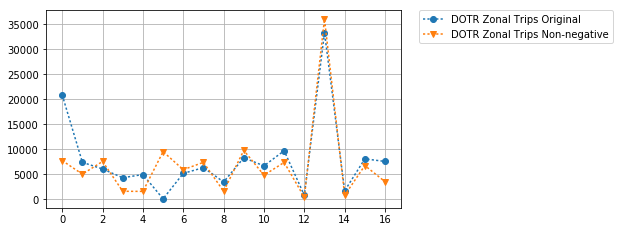

In [276]:
dep_col_name = "trips"
data_filepath = "DummyDataRegression_revised_2.csv"
regression = Regression(data_filepath)
original_df  =  pd.read_csv(data_filepath, index_col=0)

#fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)
#fitted_production_model_attr = regression2.getFittedRegressionModel(selected_feature_names_attraction, dep_col_name)
##

selected_feature_names = ["no_hh","avg_income","mem_no","no_mem_educwork"]
landuse_names = ["comm_area","park_area", "indu_area","agri_area",
                         "resi_area", "util_area"]
totalrmse = 0
print(selected_feature_names)
X_vals = regression.getXVals(selected_feature_names+landuse_names)
Y_vals = regression.getYVals(dep_col_name)
best_comb = []
best_score = 0
initialized = False

fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(221)
ax1.grid()
#hhisSum = sum(Y_vals.values)
mark1 = ax1.plot(range(0, 17), Y_vals.values, label="DOTR Zonal Trips Original", ls="dotted", marker="o")
#mark1 = ax1.plot(range(0, 17), predictions, label="DOTR Zonal Trips Regular", ls="dotted", marker="x")
mark1 = ax1.plot(range(0, 17), predictions2, label="DOTR Zonal Trips Non-negative", ls="dotted", marker="v")
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

['no_hh', 'avg_income', 'mem_no', 'no_mem_educwork']
predictionssss: [15227.309339904896, 6100.2084484095194, 5794.5578560321692, 2697.8083185720211, 3124.6751450816382, 10134.875696468578, 4999.9795857947311, 6737.4735186377229, 2239.091816976214, 8001.7221149130746, 5659.4531034483298, 6841.8305697430014, 726.10785960607018, 35005.596424286734, 1397.9807357687296, 5920.2323923124231, 4892.4494750907415]


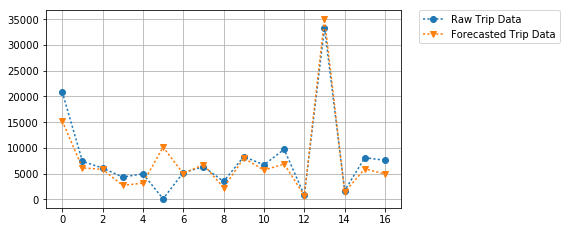

In [44]:
dep_col_name = "trips"
data_filepath = "DummyDataRegression_revised_2.csv"
regression = Regression(data_filepath)
original_df  =  pd.read_csv(data_filepath, index_col=0)

#fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)
#fitted_production_model_attr = regression2.getFittedRegressionModel(selected_feature_names_attraction, dep_col_name)
##

selected_feature_names = ["no_hh","avg_income","mem_no","no_mem_educwork"]
landuse_names = ["comm_area","park_area", "indu_area","agri_area",
                         "resi_area", "util_area"]
totalrmse = 0
print(selected_feature_names)
X_vals = regression.getXVals(selected_feature_names+landuse_names)
Y_vals = regression.getYVals(dep_col_name)
best_comb = []
best_score = 0
initialized = False

fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(221)
ax1.grid()
#hhisSum = sum(Y_vals.values)
mark1 = ax1.plot(range(0, 17), Y_vals.values, label="Raw Trip Data", ls="dotted", marker="o")
#mark1 = ax1.plot(range(0, 17), predictions, label="DOTR Zonal Trips Regular", ls="dotted", marker="x")
mark1 = ax1.plot(range(0, 17), predictions2, label="Forecasted Trip Data", ls="dotted", marker="v")
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
print("predictionssss: "+str(predictions2))
plt.show()

## 2.) A study based on MUCEP

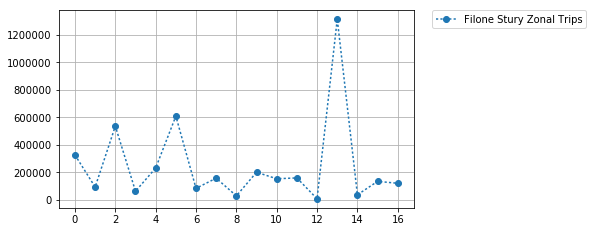

In [10]:
FILONE_MUCEP_TRIP_PROD = [326411,93639,535638,63112,231470,608551,84204,157800,29288,200924,153585
                        ,159682,7882,1313553,37197,134726,120622]
filoneSum = sum(FILONE_MUCEP_TRIP_PROD)
#ratio = hhisSum/filoneSum
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(221)
ax1.grid()
mark1 = ax1.plot(range(0, 17), FILONE_MUCEP_TRIP_PROD, label="Filone Stury Zonal Trips", ls="dotted", marker="o")
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


['no_hh', 'avg_income', 'mem_no', 'no_mem_educwork']
predictionssss: [15227.309339904896, 6100.2084484095194, 5794.5578560321692, 2697.8083185720211, 3124.6751450816382, 10134.875696468578, 4999.9795857947311, 6737.4735186377229, 2239.091816976214, 8001.7221149130746, 5659.4531034483298, 6841.8305697430014, 726.10785960607018, 35005.596424286734, 1397.9807357687296, 5920.2323923124231, 4892.4494750907415]


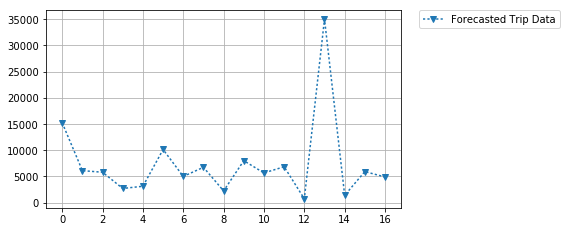

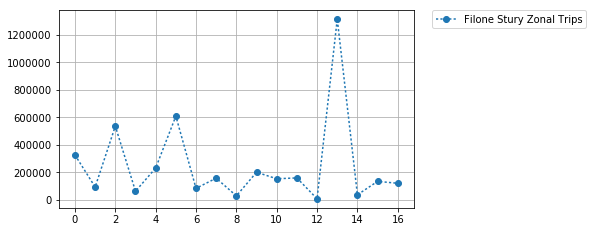

In [16]:
dep_col_name = "trips"
data_filepath = "DummyDataRegression_revised_2.csv"
regression = Regression(data_filepath)
original_df  =  pd.read_csv(data_filepath, index_col=0)

#fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)
#fitted_production_model_attr = regression2.getFittedRegressionModel(selected_feature_names_attraction, dep_col_name)
##

selected_feature_names = ["no_hh","avg_income","mem_no","no_mem_educwork"]
landuse_names = ["comm_area","park_area", "indu_area","agri_area",
                         "resi_area", "util_area"]
totalrmse = 0
print(selected_feature_names)
X_vals = regression.getXVals(selected_feature_names+landuse_names)
Y_vals = regression.getYVals(dep_col_name)
best_comb = []
best_score = 0
initialized = False

fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(221)
ax1.grid()
#hhisSum = sum(Y_vals.values)
#mark1 = ax1.plot(range(0, 17), predictions, label="DOTR Zonal Trips Regular", ls="dotted", marker="x")
mark1 = ax1.plot(range(0, 17), predictions2, label="Forecasted Trip Data", ls="dotted", marker="v")
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
print("predictionssss: "+str(predictions2))
plt.show()

fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(221)
ax1.grid()
mark1 = ax1.plot(range(0, 17), FILONE_MUCEP_TRIP_PROD, label="Filone Stury Zonal Trips", ls="dotted", marker="o")
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [14]:
FILONE_MUCEP_TRIP_PROD = [326411,93639,535638,63112,231470,608551,84204,157800,29288,200924,153585
                        ,159682,7882,1313553,37197,134726,120622]
filoneSum = sum(FILONE_MUCEP_TRIP_PROD)
ratio = hhisSum/filoneSum
FILONE_MUCEP_TRIP_PROD = [x * ratio for x in FILONE_MUCEP_TRIP_PROD]
print(str(sum(FILONE_MUCEP_TRIP_PROD)) + " " + str(hhisSum))
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(221)
ax1.grid()
mark1 = ax1.plot(range(0, 17), FILONE_MUCEP_TRIP_PROD, label="Filone Stury Zonal Trips", ls="dotted", marker="o")
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
difference = myFormattedList = [ round(elem, 1) for elem in (FILONE_MUCEP_TRIP_PROD - Y_vals.values)]
print(Y_vals.values)
print(FILONE_MUCEP_TRIP_PROD)
print([ round(elem, 1) for elem in FILONE_MUCEP_TRIP_PROD - Y_vals.values ])


NameError: name 'hhisSum' is not defined

# SCRATCH CELLS:

In [ ]:
dep_col_name = "trips"
data_filepath = "DummyDataRegression.csv"
regression = Regression(data_filepath)

data_filepath2 = "DummyDataRegressionAmenitiex.csv"
regression2 = Regression(data_filepath2)

selected_feature_names = ["no_hh","avg_income","mem_no","no_mem_educwork","comm_area","park_area", "indu_area","agri_area",
                         "resi_area", "util_area","othe_area"]
selected_feature_names_attraction = ["sust_amt","educ_amt","tran_amt","heal_amt","fina_amt","comm_amt", "ente_amt","othe_amt",
                        "comm_area", "park_area","indu_area","agri_area","resi_area","util_area","othe_area"]
fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)
fitted_production_model_attr = regression2.getFittedRegressionModel(selected_feature_names_attraction, dep_col_name)

print("Prod Intercept:"+str(fitted_production_model.intercept_)+" Coef:"+str(fitted_production_model.coef_))
print("Attr Intercept:"+str(fitted_production_model_attr.intercept_)+" Coef:"+str(fitted_production_model_attr.coef_))

dummy_data = pd.read_csv('DummyDataRegression.csv', index_col=0)
dummy_data.head()

In [ ]:
totalrmse = 0
print(selected_feature_names)
X_vals = regression.getXVals(selected_feature_names)
Y_vals = regression.getYVals(dep_col_name)

for x in range(len(X_vals.index)):
    Predicted_vals = []
    print("Test row: "+str(x))
    fitted_production_model2 = regression.kFoldTest(selected_feature_names, dep_col_name, x);
    #testdframe.head()
    #fitted_production_model2.predict(X_vals.iloc[x , :].values.reshape(1,-1))
    for z in range(len(X_vals.index)):
        #print("Actual Zone "+str(z)+": "+str(Y_vals.iloc[z]))
        #print("Predicted Zone "+str(z)+": "+str(fitted_production_model2.predict(X_vals.iloc[z , :].values.reshape(1,-1))[0]))
        Predicted_vals.append(fitted_production_model2.predict(X_vals.iloc[z , :].values.reshape(1,-1))[0])
    rms = sqrt(mean_squared_error(Y_vals.values, Predicted_vals))
    totalrmse += rms
    print("Trained using index "+str(x)+": RMSE = "+str(rms))
print("TOTAL RMSE: "+str(totalrmse))

In [ ]:
dep_col_name = "trips"
data_filepath = "DummyDataRegression.csv"
regression = Regression(data_filepath)

data_filepath2 = "DummyDataRegressionAmenitiex.csv"
regression2 = Regression(data_filepath2)

selected_feature_names = ["no_hh","avg_income","mem_no","no_mem_educwork","comm_area","park_area", "indu_area","agri_area",
                         "resi_area", "util_area","othe_area"]
selected_feature_names_attraction = ["sust_amt","educ_amt","tran_amt","heal_amt","fina_amt","comm_amt", "ente_amt","othe_amt",
                        "comm_area", "park_area","indu_area","agri_area","resi_area","util_area","othe_area"]
fitted_production_model = regression.getFittedRegressionModel(selected_feature_names, dep_col_name)
fitted_production_model_attr = regression2.getFittedRegressionModel(selected_feature_names_attraction, dep_col_name)

#print("Prod Intercept:"+str(fitted_production_model.intercept_)+" Coef:"+str(fitted_production_model.coef_))
#print("Attr Intercept:"+str(fitted_production_model_attr.intercept_)+" Coef:"+str(fitted_production_model_attr.coef_))

dummy_data = pd.read_csv('DummyDataRegression.csv', index_col=0)
dummy_data.head()

In [ ]:
dummy_data_amenities = pd.read_csv('DummyDataRegressionAmenitiex_revised.csv', index_col=0)
dummy_data_amenities.head()